/home/porepy/porepy/src/porepy/numerics/nonlinear/nonlinear_solvers.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange  # type: ignore


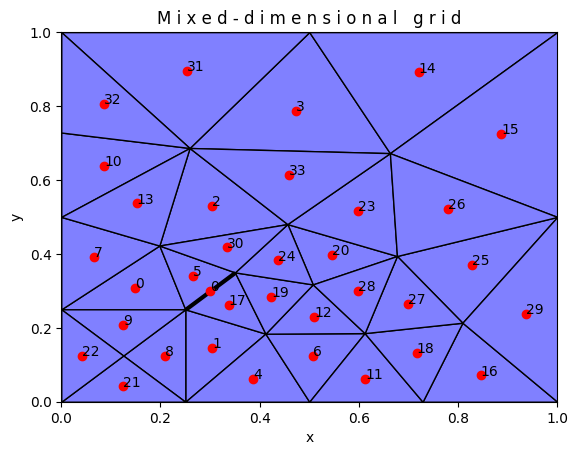

In [1]:
import porepy as pp
import numpy as np
from mat_utils import *
from plot_utils import *
from one_cell_setup import make_model
from pp_utils import make_row_col_dofs, make_reorder_contact
from pp_utils import correct_eq_groups


model = make_model()
model.prepare_simulation()
model._initialize_solver()
eq_dofs, var_dofs = make_row_col_dofs(model)
reorder = make_reorder_contact(model)
corrected_eq_dofs, corrected_eq_groups = correct_eq_groups(model)

pp.plot_grid(
    model.mdg,
    plot_2d=True,
    fracturewidth_1d=3,
    rgb=[0.5, 0.5, 1],
    info='C',
)

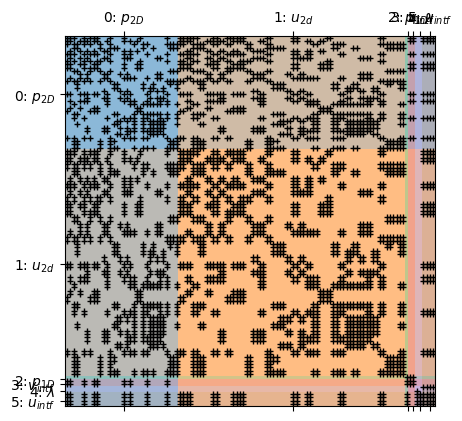

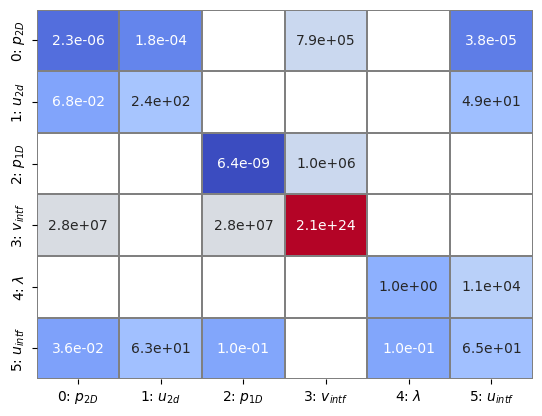

In [2]:
from block_matrix import BlockMatrixStorage


def build_S44(J: BlockMatrixStorage):
    return - J[4, 5].mat @ inv(J[5,5].mat) @ J[5, 4].mat

def build_S44_bdiag(J: BlockMatrixStorage):
    return - J[4, 5].mat @ inv_block_diag(J[5,5].mat, nd=model.nd) @ J[5, 4].mat

def make_matrix_rhs():
    model.before_nonlinear_loop()
    model.before_nonlinear_iteration()
    model.assemble_linear_system()
    mat, rhs = model.linear_system
    mat = mat[reorder]

    J = BlockMatrixStorage(
        mat=mat,
        global_row_idx=corrected_eq_dofs,
        global_col_idx=model.var_dofs,
        groups_row=corrected_eq_groups,
        groups_col=model._variable_groups,
        group_row_names=[r'$p_{2D}$', r'$u_{2d}$', r'$p_{1D}$', r'$v_{intf}$', r'$\lambda$', '$u_{intf}$'],
        group_col_names=[r'$p_{2D}$', r'$u_{2d}$', r'$p_{1D}$', r'$v_{intf}$', r'$\lambda$', '$u_{intf}$']
    )
    return J, rhs

def characteristic():
    return model._characteristic.value(model.equation_system).astype(bool)

J, rhs = make_matrix_rhs()

J[:].color_spy()
J[:].plot_max()

[False] [False] [ True]


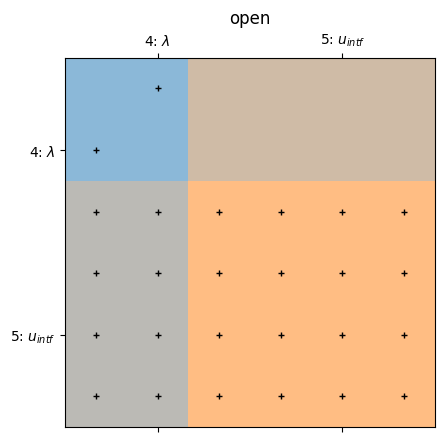

In [3]:
def make_open():
    lambdas = model.equation_system.get_variable_values(variables=[model.contact_traction_variable], iterate_index=0)
    lambdas[:] = 0
    u_intf = model.equation_system.get_variable_values(variables=[model.interface_displacement_variable], iterate_index=0)
    u_intf[:] = 0

    # lambdas[0] = 0
    lambdas[0] = -10
    lambdas[1] = 100
    # u_intf[1] = -1

    model.equation_system.set_variable_values(lambdas, variables=[model.contact_traction_variable], iterate_index=0)
    model.equation_system.set_variable_values(u_intf, variables=[model.interface_displacement_variable], iterate_index=0)

    J, rhs = make_matrix_rhs()

    sticking, sliding, open_ = model.sticking_sliding_open()
    print(sticking, sliding, open_)
    assert np.all(open_)

    return J, rhs


J, rhs = make_open()
plt.title('open')
J[[4, 5]].color_spy()
# J[[4]].matshow()

In [4]:
frac = model.mdg.subdomains(dim=1)
ad = model.mass_balance_equation(frac)

In [5]:
S44 = build_S44(J)
S44.A

array([[0., 0.],
       [0., 0.]])

[ True] [False] [False]


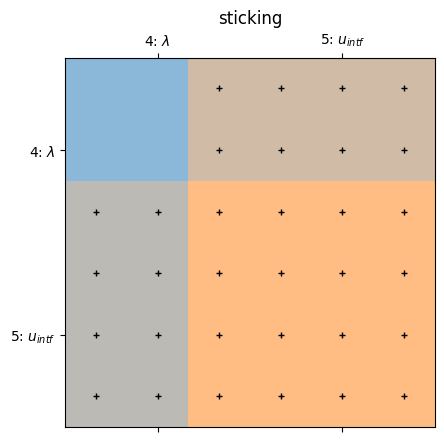

In [6]:
def make_sticking():
    lambdas = model.equation_system.get_variable_values(variables=[model.contact_traction_variable], iterate_index=0)
    lambdas[:] = 0
    u_intf = model.equation_system.get_variable_values(variables=[model.interface_displacement_variable], iterate_index=0)
    u_intf[:] = 0

    lambdas[0] = 0
    lambdas[1] = -100
    # u_intf[1] = -100

    model.equation_system.set_variable_values(lambdas, variables=[model.contact_traction_variable], iterate_index=0)
    model.equation_system.set_variable_values(u_intf, variables=[model.interface_displacement_variable], iterate_index=0)

    # u_intf[0] = 0.0005
    # model.equation_system.set_variable_values(u_intf, variables=[model.interface_displacement_variable], time_step_index=0)

    J, rhs = make_matrix_rhs()

    sticking, sliding, open_ = model.sticking_sliding_open()
    print(sticking, sliding, open_)
    
    assert np.all(sticking)

    char = characteristic()
    assert not np.any(char)

    return J, rhs


J, rhs = make_sticking()
plt.title('sticking')
J[[4, 5]].color_spy()
# J[[4]].matshow()

[ True] [False] [False]


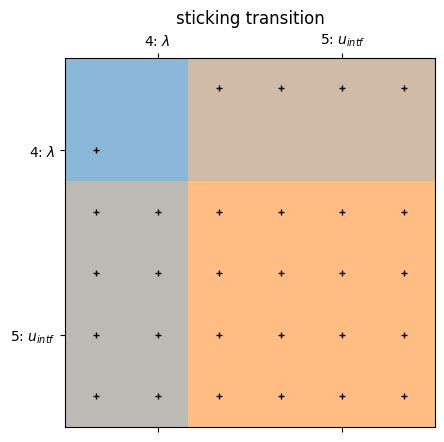

In [7]:
def make_sticking_transition():
    lambdas = np.zeros(2)
    u_intf = np.zeros(4)

    lambdas[0] = 0
    lambdas[1] = -1e-6

    model.equation_system.set_variable_values(lambdas, variables=[model.contact_traction_variable], iterate_index=0)
    model.equation_system.set_variable_values(u_intf, variables=[model.interface_displacement_variable], iterate_index=0)
    J, rhs = make_matrix_rhs()

    sticking, sliding, open_ = model.sticking_sliding_open()
    print(sticking, sliding, open_)
    
    assert np.all(sticking)

    char = characteristic()
    assert np.all(char)

    return J, rhs


J, rhs = make_sticking_transition()
plt.title('sticking transition')
J[[4, 5]].color_spy()
# J[[4]].matshow()

In [8]:
S44 = build_S44(J)
S44.A

array([[-1.50544945, 56.09804841],
       [ 0.        ,  0.        ]])

[False] [ True] [False]


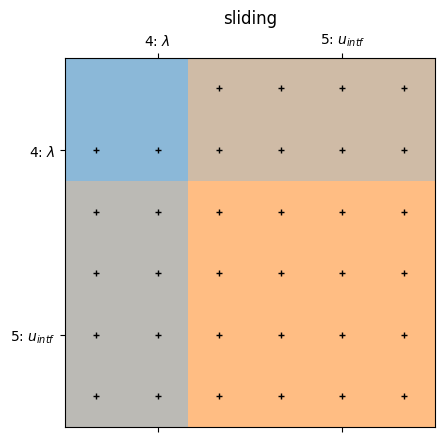

In [9]:
def make_sliding():
    lambdas = np.zeros(2)
    u_intf = np.zeros(4)

    lambdas[0] = -100
    lambdas[1] = -100
    # u_intf[1] = -100

    model.equation_system.set_variable_values(lambdas, variables=[model.contact_traction_variable], iterate_index=0)
    model.equation_system.set_variable_values(u_intf, variables=[model.interface_displacement_variable], iterate_index=0)
    J, rhs = make_matrix_rhs()

    sticking, sliding, open_ = model.sticking_sliding_open()
    print(sticking, sliding, open_)
    
    assert np.all(sliding)

    char = characteristic()
    assert not np.any(char)

    return J, rhs


J, rhs = make_sliding()
plt.title('sliding')
J[[4, 5]].color_spy()
# J[[4]].matshow()

In [10]:
S44 = build_S44(J)
S44.A

array([[-1.50544945e+00,  5.60980484e+01],
       [ 3.36275980e+03, -5.24736217e+01]])

In [11]:
S44 = build_S44_bdiag(J)
S44.A

array([[-1.38867183e+00,  5.87974415e+01],
       [ 3.15925882e+03, -5.05855937e+01]])

[False] [ True] [False]


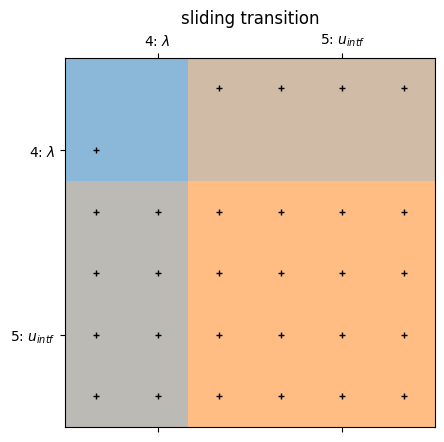

In [21]:
def make_sliding_transition():
    lambdas = np.zeros(2)
    u_intf = np.zeros(4)

    lambdas[0] = -1e-6
    lambdas[1] = -1e-6
    # u_intf[1] = -100

    model.equation_system.set_variable_values(lambdas, variables=[model.contact_traction_variable], iterate_index=0)
    model.equation_system.set_variable_values(u_intf, variables=[model.interface_displacement_variable], iterate_index=0)
    J, rhs = make_matrix_rhs()

    sticking, sliding, open_ = model.sticking_sliding_open()
    print(sticking, sliding, open_)
    
    assert np.all(sliding)

    char = characteristic()
    assert np.all(char)

    return J, rhs


J, rhs = make_sliding_transition()
plt.title('sliding transition')
J[[4, 5]].color_spy()
# J[[4]].matshow()

In [22]:
S44 = build_S44(J)
S44.A

array([[-1.50544945, 56.09804841],
       [ 0.        ,  0.        ]])

In [14]:
S44 = build_S44_bdiag(J)
S44.A

array([[-1.38867183, 58.79744152],
       [ 0.        ,  0.        ]])

####################

In [15]:
def set_some_values():
    variable_names = [
        model.pressure_variable,
        model.displacement_variable,
        model.interface_displacement_variable,
    ]
    vars = model.equation_system.get_variable_values(
        variables=variable_names, iterate_index=0
    )
    vars[:] = np.random.random(size=vars.size) * 1e-8

    model.equation_system.set_variable_values(
        vars, variables=variable_names, iterate_index=0
    )

    vars[:] = np.random.random(size=vars.size) * 1e-8
    model.equation_system.set_variable_values(
        vars, variables=variable_names, time_step_index=0
    )

In [39]:
from block_matrix import SolveSchema, make_solver
from preconditioner_mech import make_J44_inv_bdiag

J, rhs = make_sliding()

stab = -J[4, 5].mat @ inv_block_diag(J[5, 5].mat, nd=model.nd) @ J[5, 4].mat
stab[1] = 0

J44 = J[4, 4].mat
S44 = J[4, 4].mat - stab
S44_inv = inv_block_diag(S44, nd=model.nd)

def make_J44_inv_no_sliding_tangential(model, bmat, idx_zeros):
    stab = -bmat[4, 5].mat @ inv_block_diag(bmat[5, 5].mat, nd=model.nd) @ bmat[5, 4].mat
    zeros_2d = np.zeros(len(idx_zeros) * 2, dtype=bool)
    zeros_2d[np.array(idx_zeros) * 2 + 1] = True
    stab[zeros_2d] = 0

    S44 = J[4, 4].mat - stab
    return inv_block_diag(S44, nd=model.nd)

[False] [ True] [False]


In [40]:
make_J44_inv_no_sliding_tangential(model, J, [0])

<2x2 sparse matrix of type '<class 'numpy.float64'>'
	with 4 stored elements in Compressed Sparse Row format>